In [12]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import mean_squared_error
import ast
import operator
import datetime
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt

In [2]:
zip_dictionary = {'San Francisco': 94107,
                 'Redwood City': 94063,
                 'Palo Alto': 94301,
                 'Mountain View': 94041,
                 'San Jose': 95113}

In [3]:
"""read station_data.csv file

returns
    station_dictionary {id: [lat, long, dock count,zip]}
    
"""
station_dic = {}
with open("data/station_data.csv","r") as station_file:
    station_file.readline() #skip the first line
    for line in station_file:
        line = line.replace("\r\n","")
        fields = line.split(",")
        station_dic[int(fields[0])] = []
        for i in range(2,5):
            station_dic[int(fields[0])].append(ast.literal_eval(fields[i]))
        
        station_dic[int(fields[0])].append(zip_dictionary[fields[5]])
print ("Example of station id 5:", station_dic[5])
        


('Example of station id 5:', [37.331415, -121.8932, 19, 95113])


In [4]:
"""read weather_data.csv file

returns
    weather_dictionary {(date, zip): [Max Temperature, Mean Temperature, ...]}
"""

weather_dic = {}
events_dic = {'': [1,0,0,0,0], 'Rain': [0,1,0,0,0], 'Fog-Rain': [0,0,1,0,0], 'Rain-Thunderstorm': [0,0,0,1,0], 'Fog': [0,0,0,0,1]}
with open("data/weather_data.csv","r") as weather_file:
    weather_file.readline() #skip the first line
    for line in weather_file:
        line = line.replace("\r\n","")
        fields = line.split(",")
        weather_dic[(fields[0],int(fields[-1]))]= []
        for i in range(1,len(fields)-1):
            if i == (len(fields)-3):
                weather_dic[(fields[0],int(fields[-1]))] += events_dic[fields[i]]
            elif fields[i]=="":
                weather_dic[(fields[0],int(fields[-1]))].append(0)
            else:
                weather_dic[(fields[0],int(fields[-1]))].append(ast.literal_eval(fields[i]))
print ("Example of weather at (17/09/2014,94107):",weather_dic[("17/09/2014",94107)])
        

('Example of weather at (17/09/2014,94107):', [77, 69, 61, 64, 58, 55, 84, 67, 50, 29.83, 29.8, 29.75, 10, 10, 9, 21, 9, 29, 0.001, 5, 0, 1, 0, 0, 0, 267])


In [5]:
"""read trip_data.csv file

returns
    trip_started_dictionary {(date, station id, hour): count}
    trip_ended_dictionary {(date, station id, hour): count}
    net_rate_dictionary {(date, station id, hour): net rate}
    top_route_dictionary {station id: [station id1, station id2,...]}
    route_dictionary {(station1,station2):count}
"""
trip_started_dictionary = {}
trip_ended_dictionary = {}
net_rate_dictionary = {}
top_route_dictionary = {}
route_dictionary = {}
date_list = []
type_dic = {"Subscriber":0, "Customer":1}
count = 0
with open("data/trip_data.csv","r") as trip_file:
    trip_file.readline() #skip the first line
    for line in trip_file:
        line = line.replace("\n","").replace("\r","")
        fields = line.split(",")
        start_date = fields[1].split(" ")[0]
        start_station = int(fields[2])
        start_hour = int(fields[1].split(" ")[1].split(":")[0])
        end_date = fields[3].split(" ")[0]
        end_station =  int(fields[4])
        end_hour = int(fields[3].split(" ")[1].split(":")[0])
        sub_type = type_dic[fields[-1]]

        #print (date,start_station,start_hour,end_station,end_hour,sub_type)
        if (start_date,start_station,start_hour) in trip_started_dictionary:
            trip_started_dictionary[(start_date,start_station,start_hour)] +=1
        else:
            trip_started_dictionary[(start_date,start_station,start_hour)] = 1
        if (start_date,start_station,start_hour) not in trip_ended_dictionary:
            trip_ended_dictionary[(start_date,start_station,start_hour)] = 0
        if (end_date,end_station,end_hour) in trip_ended_dictionary:
            trip_ended_dictionary[(end_date,end_station,end_hour)] +=1
        else:
            trip_ended_dictionary[(end_date,end_station,end_hour)] =1
            
        if (end_date,end_station,end_hour) not in trip_started_dictionary:
            trip_started_dictionary[(end_date,end_station,end_hour)] = 0
        if (start_station,end_station) not in route_dictionary:
            route_dictionary[(start_station,end_station)] = 1
            route_dictionary[(end_station,start_station)] = 1
        else:
            route_dictionary[(start_station,end_station)] += 1
            route_dictionary[(end_station,start_station)] += 1
        
        
for station1 in station_dic:
    station1_route = {}
    for station2 in station_dic:
        if (station1,station2) in route_dictionary:
            station1_route[station2] = route_dictionary[(station1,station2)]
    station1_route = sorted(station1_route.items(),key=operator.itemgetter(1),reverse=True)
    top_route_dictionary[station1] = station1_route 

     

for key in trip_ended_dictionary:
    net_rate_dictionary[key] = trip_ended_dictionary[key] - trip_started_dictionary[key]
print("Example of net rate dictionary:", dict(list(net_rate_dictionary.items())[0:20]))
print("Example of top route dictionary:", dict(list(top_route_dictionary.items())[0:20]))
        

('Example of net rate dictionary:', {('20/07/2015', 77, 9): 5, ('30/04/2015', 74, 17): 1, ('02/07/2015', 74, 14): 0, ('27/09/2014', 47, 18): -2, ('31/03/2015', 9, 11): 1, ('11/03/2015', 28, 9): -4, ('02/11/2014', 65, 17): 2, ('27/04/2015', 4, 13): 1, ('02/05/2015', 65, 10): 2, ('20/07/2015', 32, 6): -1, ('15/07/2015', 90, 7): -1, ('17/06/2015', 88, 14): 0, ('26/02/2015', 89, 12): -1, ('09/10/2014', 57, 21): -1, ('16/10/2014', 42, 7): 0, ('29/07/2015', 65, 0): 1, ('31/03/2015', 46, 18): 1, ('04/08/2015', 76, 2): 1, ('26/01/2015', 77, 7): 2, ('27/08/2015', 66, 11): 1})
('Example of top route dictionary:', {2: [(4, 2446), (6, 1301), (11, 1129), (7, 790), (13, 653), (84, 645), (9, 611), (5, 575), (10, 518), (3, 491), (16, 229), (8, 215), (12, 206), (2, 153), (80, 25), (14, 23), (28, 2)], 3: [(2, 491), (3, 377), (10, 133), (84, 122), (6, 100), (11, 69), (12, 67), (4, 63), (7, 59), (9, 43), (5, 39), (14, 39), (16, 35), (8, 19), (80, 14), (13, 9), (28, 2), (29, 1)], 4: [(2, 2446), (14, 510), 

In [11]:
""" Input X_data and Output y_data preprocessing"""

season_dic = {"01":"spring","02":"spring","03":"spring","04":"summer","05":"summer","06":"summer","07":"summer",
             "08":"fall","09":"fall","10":"winter","11":"winter","12":"winter"}
station_data_array = []
conntectedStation_data_array = []
y_data = []

net_season = {}
net_weekday = {}

for item in net_rate_dictionary:
    date, station_id, hour = item
    label = net_rate_dictionary[item]
    lat, longtitue, dockcount,zip_code  = station_dic[station_id]
    weather = weather_dic[(date,zip_code)]
    dd,mm,yy = date.split("/")
    
    
    weekday = datetime.date(int(yy),int(mm),int(dd)).strftime("%A")
    season = season_dic[mm]
    if weekday not in net_weekday:
        net_weekday[weekday] = [0]*24
        net_weekday[weekday][hour] = label
    else:
        net_weekday[weekday][hour] += label

    if season not in net_season:
        net_season[season] = [0]*24
        net_season[season][hour] = label
    else:
        net_season[season][hour] += label    
        
    
    

print net_season,net_weekday


    

{'summer': [64, 20, 21, -5, -33, -119, -465, -1307, -1396, 1939, 221, -289, -307, -35, -72, -491, -1135, 236, 1620, 743, 371, 185, 185, 48], 'fall': [25, 6, 0, 7, -10, -28, -215, -790, -551, 881, 87, -229, -13, -42, -44, -329, -600, 180, 780, 445, 238, 59, 80, 66], 'winter': [56, 12, 17, 9, 3, -48, -298, -961, -682, 1059, 167, -289, -167, 74, -53, -292, -473, 94, 946, 477, 99, 107, 91, 53], 'spring': [69, -16, 33, -12, -13, -61, -348, -950, -980, 1347, 262, -239, -211, 49, -80, -283, -797, 393, 975, 447, 215, 85, 70, 42]} {'Monday': [17, 3, 0, 2, -15, -45, -238, -834, -685, 1178, 155, -13, -43, 24, -39, -261, -715, 53, 812, 304, 183, 75, 70, 11], 'Tuesday': [34, 6, 4, 4, -15, -42, -237, -872, -778, 1268, 300, -180, -115, 159, -83, -249, -743, 83, 761, 379, 146, 130, 58, 7], 'Friday': [23, -2, 19, -8, -4, -45, -235, -625, -588, 803, 163, -120, -86, -35, 1, -280, -524, 232, 683, 335, 108, 8, 21, 73], 'Wednesday': [28, 4, 2, -2, -12, -56, -295, -797, -638, 1085, 280, -109, -51, 67, -9, -2

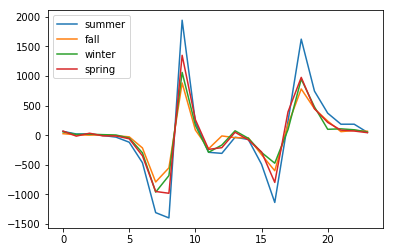

In [24]:
hour_axis = [x for x in range(0,24)]
for key in net_season:
    plt.plot(hour_axis, net_season[key],label=key)
plt.legend()
plt.show()

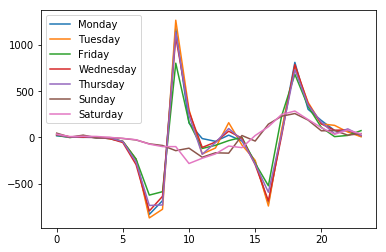

In [25]:
hour_axis = [x for x in range(0,24)]
for key in net_weekday:
    plt.plot(hour_axis, net_weekday[key],label=key)
plt.legend()
plt.show()